In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [2]:
import torch
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import random
from src.useful_functions import *

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = torch.distributions.uniform.Uniform(0,15)
#p_x = torch.distributions.exponential.Exponential(0.5)

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

Text(0, 0.5, 'Encoding')

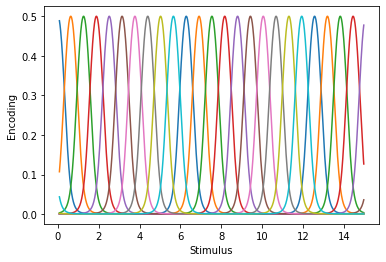

In [4]:
#CIRCULAR ENCODER/DECODER TRY
enc_circ = CircularBernoulliEncoder(N)
dec = MLPDecoder(N,200)
r = enc_circ.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)

plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")


#TO DO: circular decoder with von mises circular distribution + circular rate

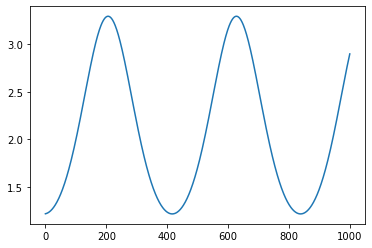

In [5]:
r = enc_circ.sample(x_fine,10)
a = 2
theta = torch.as_tensor(math.pi)
k = 0.5
func = a*torch.exp(k*torch.cos(x_fine - theta))
plt.plot(func)



In [6]:
def distortion_circular(x,encoder,decoder,lat_samp=10,tau=0.5):
    #Logit r|x
    l_r_x = encoder(x)
    bsize,N = l_r_x.shape
    #ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
    eps = torch.rand(bsize,lat_samp,N)
    r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/tau)
    mu_dec,sigma2_dec = decoder(r)
    k = (1/sigma2_dec).detach()
    mp = mu_dec*k
    logq_x_r = k*torch.cos(x-mu_dec)  - torch.log(2*torch.as_tensor(math.pi))  - torch.log(scipy.special.kn(0,k))
    D = -logq_x_r.mean()
    return D


In [7]:
l_r_x = enc_circ(x_fine)
bsize,N = l_r_x.shape
#ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
eps = torch.rand(bsize,10,N)
r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/0.5)
mu_dec,sigma2_dec = dec(r)
k = (1/sigma2_dec).detach()
mp = mu_dec*k
logq_x_r = k*torch.cos(x_fine-mu_dec) - torch.log(2*torch.as_tensor(math.pi))  - torch.log(scipy.special.kn(0,k))
D = -logq_x_r.mean()
logq_x_r
D




tensor(0.7016, dtype=torch.float64, grad_fn=<NegBackward>)

In [13]:
q = rate_ising(N)
loss = q(enc_circ,x_fine)
dist = distortion_circular(x_fine,enc_circ,dec)

In [24]:
ciao = scipy.special.kn(0,5)
r = enc_circ.sample(x_fine,10)

In [14]:
#Traning on the entire set of parameters
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(enc_circ.parameters(),dec.parameters(),q.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        rate = q(enc_circ,x_)
        dist = distortion_circular(x_,enc_circ,dec)
        loss = rate + dist
        print(dist)
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())

tensor(0.8625, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(nan, dtype=torch.float64, grad_fn=<Neg

KeyboardInterrupt: 

Text(0, 0.5, 'Encoding')

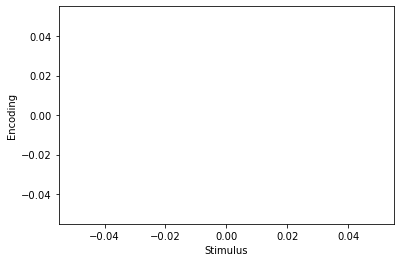

In [27]:
plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [28]:
r = enc_circ.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()

ValueError: The parameter logits has invalid values